In [1]:
from pyulog import ULog
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [2]:
DATA_DIR = "data/1/"
video_path = os.path.join(DATA_DIR, "mp4.mp4")
output_path = os.path.join(DATA_DIR, "output.mp4")
SAVE_EVERY_N = 1
PLOT_EVERY_N = 10

In [3]:


ulog = ULog("data/1/ulg.ulg")
for d in ulog.data_list:
    df = pd.DataFrame(d.data)
    print(d.name)


actuator_armed
actuator_motors
actuator_outputs
battery_status
config_overrides
control_allocator_status
cpuload
distance_sensor_mode_change_request
ekf2_timestamps
esc_status
estimator_aid_src_baro_hgt
estimator_aid_src_fake_hgt
estimator_aid_src_fake_pos
estimator_aid_src_gnss_hgt
estimator_aid_src_gnss_pos
estimator_aid_src_gnss_vel
estimator_aid_src_gravity
estimator_aid_src_mag
estimator_baro_bias
estimator_event_flags
estimator_gps_status
estimator_innovation_test_ratios
estimator_innovation_variances
estimator_innovations
estimator_sensor_bias
estimator_states
estimator_status
estimator_status_flags
event
failsafe_flags
failure_detector_status
gripper
home_position
hover_thrust_estimate
landing_gear
manual_control_setpoint
mission_result
navigator_mission_item
navigator_status
parameter_update
position_setpoint_triplet
rate_ctrl_status
rtl_status
rtl_time_estimate
sensor_accel
sensor_baro
sensor_combined
sensor_gps
sensor_gyro
sensor_gyro_fft
sensor_mag
sensor_selection
sensors_

In [4]:
ulog_path = os.path.join(DATA_DIR, "ulg.ulg")
ulog = ULog(ulog_path)

MONITOR_CSV = [
    "vehicle_attitude",
    "sensor_accel_0.csv",
    "sensor_gyro_0.csv",
    "sensor_mag_0.csv",
    "sensor_baro_0.csv",
    "sensor_gps_0.csv",
    "vehicle_local_position_0.csv",
    "vehicle_global_position_0.csv"
]


for data in ulog.data_list:
    if data.name in MONITOR_CSV:
        df = pd.DataFrame(data.data)

        # Convert PX4 timestamp to seconds
        if "timestamp" in df.columns:
            df["timestamp_s"] = df["timestamp"] * 1e-6

        filename = f"{data.name}_{data.multi_id}.csv"
        filepath = os.path.join(DATA_DIR, "csv", filename)
        df.to_csv(filepath, index=False)
        print(f"Saved {filename}")


Saved vehicle_attitude_0.csv


In [47]:
from utilities.plt import PX4CSVPlotter

plotter = PX4CSVPlotter("data/1/csv")

all_data = plotter.plot_all(plot=False)
angles = all_data["att"]
gps = all_data["gps"]

gps_time, gps_lon, gps_lat, gps_alt = gps
gps_alt = np.array(gps_alt)

yaw_att  = np.array(angles[0])
pitch_att = np.array(angles[1])
roll_att   = np.array(angles[2])
time_att  = np.array(angles[3])

roll_norm  = (roll_att + 180) % 360 - 180
pitch_norm = (pitch_att + 180) % 360 - 180
yaw_norm   = (yaw_att + 180) % 360 - 180

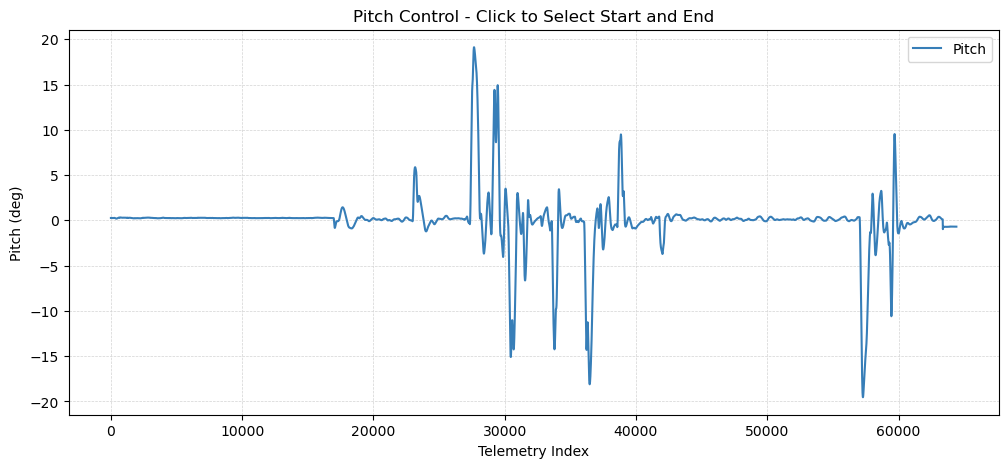

In [6]:
import matplotlib.pyplot as plt
import mplcursors
import numpy as np

# --- plot pitch ---
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pitch_norm, label="Pitch")
ax.set_title("Pitch Control - Click to Select Start and End")
ax.set_xlabel("Telemetry Index")
ax.set_ylabel("Pitch (deg)")
ax.grid(True)
ax.legend()

# --- interactive cursor ---
cursor = mplcursors.cursor(ax, hover=True)

selected = []

def on_click(sel):
    idx = int(round(sel.target[0]))
    selected.append(idx)
    print(f"Selected index: {idx}")

    if len(selected) == 2:
        start_idx, end_idx = selected
        if start_idx > end_idx:
            start_idx, end_idx = end_idx, start_idx

        start_time = gps_time[start_idx]
        end_time = gps_time[end_idx]

        print("\n✅ FINAL RESULT")
        print("Start index:", start_idx, "Start time:", start_time)
        print("End index:", end_idx, "End time:", end_time)
        print("Duration (s):", end_time - start_time)

        plt.close(fig)

cursor.connect("add", on_click)

plt.show()


In [7]:
import cv2
import numpy as np
from tqdm import tqdm

cap = cv2.VideoCapture(video_path)
frames = []
frame_idx = 0

# Get total frames for tqdm progress
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with tqdm(total=total_frames, desc="Reading frames") as pbar:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % SAVE_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)

        frame_idx += 1
        pbar.update(1)

cap.release()

frames = np.array(frames)
print("Frames shape:", frames.shape)


Reading frames: 100%|██████████| 5969/5969 [00:32<00:00, 184.75it/s]


Frames shape: (5969, 960, 1280, 3)


In [9]:
import cv2
import numpy as np

# --- Load video and get fps ---
cap = cv2.VideoCapture(video_path)
FPS = cap.get(cv2.CAP_PROP_FPS)

# --- Parameters ---
THRESH = 1        # motion threshold (tune if needed)
MIN_STATIC_FRAMES = 1  # how many frames must stay static to confirm end

prev_frame = None
motion = []

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if prev_frame is None:
        prev_frame = gray
        frame_idx += 1
        continue

    # compute difference
    diff = cv2.absdiff(gray, prev_frame)
    mean_diff = diff.mean()
    motion.append(mean_diff)

    prev_frame = gray
    frame_idx += 1

cap.release()

motion = np.array(motion)

# --- Detect start ---
start_frame = np.argmax(motion > THRESH)

# --- Detect end ---
# Find last index where motion exceeds threshold
last_motion = np.where(motion > THRESH)[0]
end_frame = last_motion[-1] + MIN_STATIC_FRAMES if len(last_motion) else 0

cap = cv2.VideoCapture(video_path)
FPS = cap.get(cv2.CAP_PROP_FPS)

cap.release()

start_frame -=1

end_time = end_frame / FPS
#!!!!!
#### Adjust start frame to 20.9 seconds to be more precise
#!!!!!
start_frame = 20.9 * FPS
start_time = start_frame / FPS

print("Start frame index:", start_frame)
print("End frame index:", end_frame)
print("Start time (s):", start_time)
print("End time (s):", end_time)
print("Duration (s):", end_time - start_time)

Start frame index: 270.6307162319293
End frame index: 5925
Start time (s): 20.9
End time (s): 457.5700117272575
Duration (s): 436.67001172725753


In [48]:
M = len(yaw_norm)
N = M

idx = np.linspace(0, M-1, N).astype(int)

gps_time = np.arange(N)
yaw_norm   = yaw_norm[idx]
pitch_norm = pitch_norm[idx]
roll_norm  = roll_norm[idx]

old_len = len(gps_alt)

x_old = np.linspace(0, 1, old_len)
x_new = np.linspace(0, 1, N)

gps_alt = np.interp(x_new, x_old, gps_alt)


print(gps_time.shape)
print(yaw_norm.shape)
print(pitch_norm.shape)
print(roll_norm.shape)


(64409,)
(64409,)
(64409,)
(64409,)


In [49]:

import matplotlib.pyplot as plt

# Plot pitch_norm in a separate window
plt.figure(figsize=(14, 6))
plt.plot(pitch_norm, label="Pitch")
plt.title("Pitch Norm")
plt.xlabel("Telemetry Index")
plt.ylabel("Pitch (deg)")
plt.grid(True)
plt.legend()
plt.show()


In [50]:
VIDEO_START_MESS = 21        # video start time in seconds
VIDEO_END_MESS = 457.5700117272575        # video end time in seconds
TELEMETRY_START_IDX = 16970  # telemetry start index
TELEMETRY_END_IDX = 63418    # telemetry end index

frames_cut = frames[int(start_frame):int(end_frame)]

gps_time_cut = gps_time[TELEMETRY_START_IDX:TELEMETRY_END_IDX]
yaw_cut      = yaw_norm[TELEMETRY_START_IDX:TELEMETRY_END_IDX]
pitch_cut    = pitch_norm[TELEMETRY_START_IDX:TELEMETRY_END_IDX]
roll_cut     = roll_norm[TELEMETRY_START_IDX:TELEMETRY_END_IDX]
gps_alt_cut  = gps_alt[TELEMETRY_START_IDX:TELEMETRY_END_IDX]

print("gps_time_cut:", gps_time_cut.shape)
print("yaw_cut:", yaw_cut.shape)
print("pitch_cut:", pitch_cut.shape)
print("roll_cut:", roll_cut.shape)
print("gps_alt_cut:", gps_alt_cut.shape)
print("frames_cut:", frames_cut.shape)

gps_time_cut: (46448,)
yaw_cut: (46448,)
pitch_cut: (46448,)
roll_cut: (46448,)
gps_alt_cut: (46448,)
frames_cut: (5655, 960, 1280, 3)


In [51]:
import matplotlib.pyplot as plt

# Plot pitch_norm in a separate window
plt.figure(figsize=(14, 6))
plt.plot(pitch_cut , label="Pitch")
plt.title("Pitch Norm")
plt.xlabel("Telemetry Index")
plt.ylabel("Pitch (deg)")
plt.grid(True)
plt.legend()
plt.show()


In [52]:
M = len(frames_cut)
N = M

idx = np.linspace(0, len(yaw_cut) - 1, N).astype(int)

gps_time_cut = np.arange(N)                # same as your style
yaw_cut      = yaw_cut[idx]
pitch_cut    = pitch_cut[idx]
roll_cut     = roll_cut[idx]

old_len = len(gps_alt_cut)
x_old = np.linspace(0, 1, old_len)
x_new = np.linspace(0, 1, N)

gps_alt_cut = np.interp(x_new, x_old, gps_alt_cut)

print("gps_time_cut:", gps_time_cut.shape)
print("yaw_cut:", yaw_cut.shape)
print("pitch_cut:", pitch_cut.shape)
print("roll_cut:", roll_cut.shape)
print("gps_alt_cut:", gps_alt_cut.shape)
print("frames_cut:", frames_cut.shape)

gps_time_cut: (5655,)
yaw_cut: (5655,)
pitch_cut: (5655,)
roll_cut: (5655,)
gps_alt_cut: (5655,)
frames_cut: (5655, 960, 1280, 3)


In [54]:
import matplotlib.pyplot as plt

# Plot pitch_norm in a separate window
plt.figure(figsize=(14, 6))
plt.plot(gps_alt_cut , label="Pitch")
plt.title("Pitch Norm")
plt.xlabel("Telemetry Index")
plt.ylabel("Pitch (deg)")
plt.grid(True)
plt.legend()
plt.show()


In [55]:
import matplotlib.pyplot as plt
import numpy as np

print("gps_time_cut:", gps_time_cut.shape)
print("gps_alt_cut:", gps_alt_cut.shape)
print("pitch_cut:", pitch_cut.shape)
print("roll_cut:", roll_cut.shape)

fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# 1) gps_time_cut
axs[0].plot(gps_time_cut)
axs[0].set_title("gps_time_cut")
axs[0].grid(True)

# 2) gps_alt_cut
axs[1].plot(gps_alt_cut)
axs[1].set_title("gps_alt_cut")
axs[1].grid(True)

# 3) pitch_cut
axs[2].plot(pitch_cut)
axs[2].set_title("pitch_cut")
axs[2].grid(True)

# 4) roll_cut
axs[3].plot(roll_cut)
axs[3].set_title("roll_cut")
axs[3].grid(True)

plt.tight_layout()
plt.show()


gps_time_cut: (5655,)
gps_alt_cut: (5655,)
pitch_cut: (5655,)
roll_cut: (5655,)


In [57]:
import cv2
import numpy as np

print("gps_time_cut:", gps_time_cut.shape)
print("yaw_cut:", yaw_cut.shape)
print("pitch_cut:", pitch_cut.shape)
print("roll_cut:", roll_cut.shape)
print("frames_cut:", frames_cut.shape)

# Ensure lengths match
N = min(len(frames_cut), len(gps_time_cut), len(gps_alt_cut), len(pitch_cut), len(roll_cut))

T = 1 / 30

for i in range(N):
    frame = frames_cut[i].copy()
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    text = (
        f"Idx: {i} | "
        f"Time: {gps_time_cut[i]:.2f}s | "
        f"Alt: {gps_alt_cut[i]:.2f}m | "
        f"Pitch: {pitch_cut[i]:.2f} | "
        f"Roll: {roll_cut[i]:.2f}"
    )

    cv2.putText(
        frame_bgr,
        text,
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2
    )

    cv2.imshow("Telemetry Video", frame_bgr)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    cv2.waitKey(int(T * 1000))

cv2.destroyAllWindows()


gps_time_cut: (5655,)
yaw_cut: (5655,)
pitch_cut: (5655,)
roll_cut: (5655,)
frames_cut: (5655, 960, 1280, 3)
